In [ ]:
import sys; sys.path.append('..'); from wwa import *


xn,xx,yn,yx = [27,41,-12,2]
mapproj = cartopy.crs.PlateCarree()

sf = gpd.read_file("sf")

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/"

sites = ["Mathare, Kenya", "Mai Mahiu, Kenya", "Nairobi, Kenya", "Dar es Salaam, Tanzania", "Bujumbura, Burundi"]
px = pd.DataFrame.from_dict({s : get_latlon(s) for s in sites}).transpose()

In [ ]:
sf_ch = gpd.read_file("sf_centralHighlands")
sf_lv = gpd.read_file("sf_lvictoriaBasin")
sf_tc = gpd.read_file("sf_tanzaniaCoast")

In [94]:
sf_hybas04 = gpd.read_file("sf_hybas04")

# Physical geography & climatology

In [91]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(xn-5,xx+5), lat = slice(yn-5,yx+5))

# load Koppen-Geiger classificatins, group into broader categories
kg = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc").kg_cat.sel(lon = slice(xn-5,xx+5), lat = slice(yn-5,yx+5))
kg_grouped = xr.apply_ufunc(np.digitize, kg, kwargs={'bins': [0.5,3.5,7.5,16.5,28.5,30]})

In [97]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : [xn,xx,yn,yx]}, gridspec_kw = {"width_ratios" : [1.3,1]})
plt.subplots_adjust(wspace = 0.3)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
v = 500
elev_kwargs = {"cmap" : "terrain",
               "vmin" : -v, 
               "vmax" : v*4}    # aim to keep 1:4 ratio to change from blue to green at zero
elev.plot(ax = ax, **elev_kwargs, cbar_kwargs = {"label" : "Elevation (m above sea level)"})#, "location" : "bottom", "fraction" : 0.05, "shrink" : 0.75})

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)

# add box around area of interest
# hybas04.boundary.plot(ax = ax, color = "darkblue", lw = 1)
# sf.boundary.plot(ax = ax, color = "darkred")
ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.3)
ax.set_title("Elevation & river basins")

sf_lv.boundary.plot(ax = ax, color = "darkred", lw = 1)
sf_tc.boundary.plot(ax = ax, color = "darkred", lw = 1)
sf_ch.boundary.plot(ax = ax, color = "darkred", lw = 1)

# sf_hybas04.boundary.plot(ax = ax, color = "darkblue")
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1]
kg_grouped.where(kg_grouped == 1).plot(ax = ax, cmap = "Reds", add_colorbar = False)      # tropical
kg_grouped.where(kg_grouped == 2).plot(ax = ax, cmap = "Oranges", add_colorbar = False)   # arid
kg_grouped.where(kg_grouped == 3).plot(ax = ax, cmap = "Greens", add_colorbar = False)    # temperate
kg_grouped.where(kg_grouped == 4).plot(ax = ax, cmap = "Blues", add_colorbar = False)     # cold
kg_grouped.where(kg_grouped == 5).plot(ax = ax, cmap = "Purples", add_colorbar = False)   # polar

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

# add box around area of interest
# sf.boundary.plot(ax = ax, color = "darkred")
ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)
sf_lv.boundary.plot(ax = ax, color = "darkred", lw = 1)
sf_tc.boundary.plot(ax = ax, color = "darkred", lw = 1)
sf_ch.boundary.plot(ax = ax, color = "darkred", lw = 1)

plt.legend(handles = [matplotlib.patches.Patch(color = "red", label = "Tropical", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "orange", label = "Arid", alpha = 0.5), 
                      matplotlib.patches.Patch(color = "green", label = "Temperate", alpha = 0.5), 
#                       matplotlib.patches.Patch(color = "tab:blue", label = "Cold", alpha = 0.5),
#                       matplotlib.patches.Patch(color = "purple", label = "Polar", alpha = 0.3)
                     ], 
           edgecolor = "w", loc = "lower right")

plt.title("Koppen-Geiger climatology")

plt.savefig("fig/physical-geography.png")

# Compare obs time series

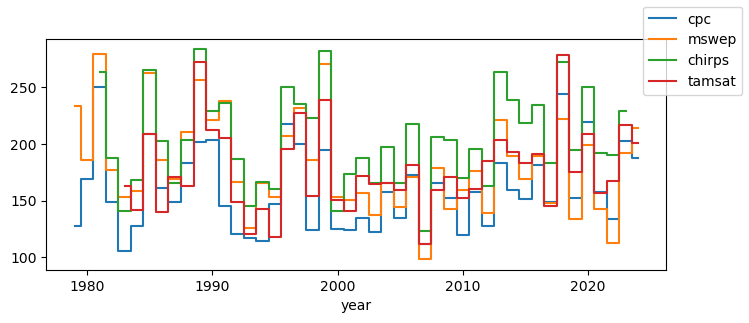

In [21]:
datasets = ["cpc", "mswep", "chirps", "tamsat"]

fig, ax = plt.subplots(figsize = (8,3), dpi = 100)
for ds in datasets:
    df = pd.read_csv("ts/EA-floods_rx30day_obs_"+ds+".dat", comment = "#", sep = " ", names = ["year", "pr"], index_col = "year")
    df.plot(ax = ax, drawstyle = "steps-mid", legend = False)
    
fig.legend(datasets)

# Linear trend in rx30day
Should only be used for quick comparison - final version should use the fitted GEV & give return periods

In [95]:
def qfit(x):
    
    gmst = pd.read_csv("data/gmst.txt", comment = "#", sep = " +", engine = "python", header = None, names = ["year", "gmst"], index_col = 0).to_xarray().gmst
    x = x.assign_coords(time = gmst.sel(year = x.time.dt.year)).rename(time = "gmst")
    
    lfit = x.polyfit("gmst", deg = 1).polyfit_coefficients
    lfitted = xr.polyval(x.gmst, lfit)
    
    lres = x - lfitted
    
    return {"coef" : lfit, "fitted" : lfitted, "res" : lres}


In [74]:
ndays = 30

datasets = ["cpc", "mswep", "chirps", "tamsat"]
obs = {ds : xr.open_dataset("data/rx"+str(ndays)+"day-MAM_gridded_"+ds+".nc").pr for ds in datasets}
lfits = {ds : qfit(obs[ds]) for ds in datasets}

## Linear association with GMST

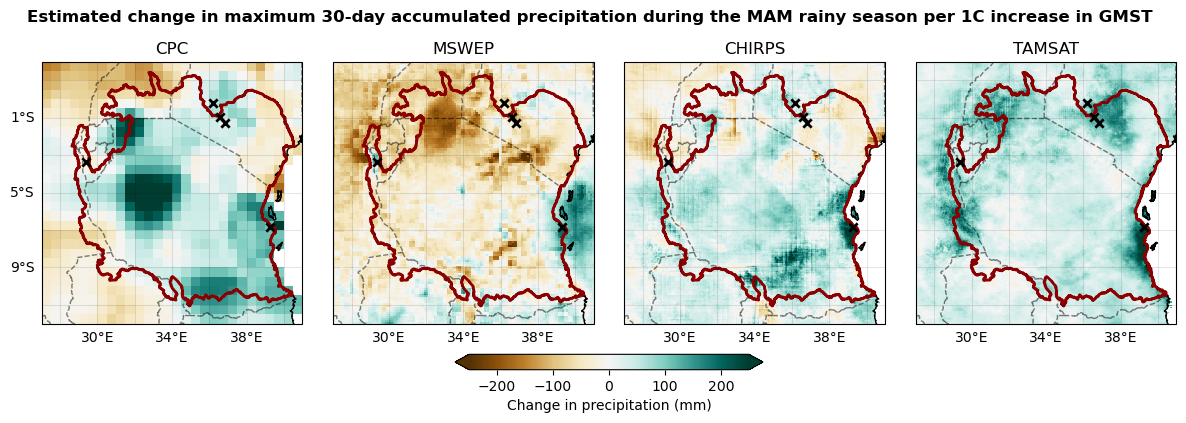

In [75]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)

v = 250

for i in range(4):
    ds = datasets[i]
    da = lfits[ds]["coef"].sel(degree = 1)
    ax = axs[i]
    
    cbar = da.plot(ax = ax, cmap = "BrBG", vmin = -v, vmax = v, add_colorbar = False)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.colorbar(cbar, ax = axs, location = "bottom", label = "Change in precipitation (mm)", fraction = 0.05, pad = 0.1, extend = "both")
plt.suptitle("Estimated change in maximum "+str(ndays)+"-day accumulated precipitation during the MAM rainy season per 1C increase in GMST", fontweight = "bold", y = 1.01)

plt.savefig("fig/rx"+str(ndays)+"day_gridded-fit_linear-trend.png")

## 2024 event

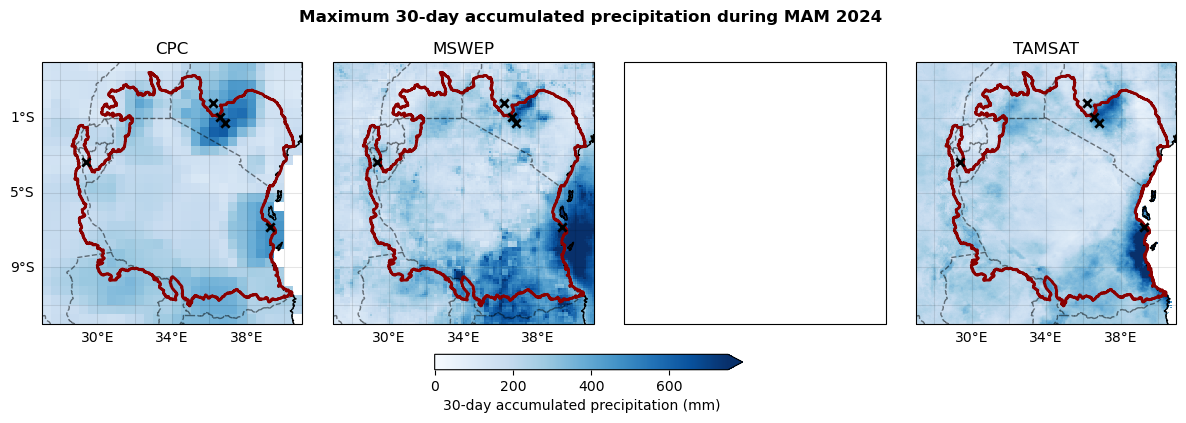

In [76]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)

v = {"30" : 750, "60" : 1500}[str(ndays)]

for i in range(4):
    ds = datasets[i]
    if ds == "chirps": continue
    da = obs[ds].sel(time = "2024")
    ax = axs[i]
    
    cbar = da.plot(ax = ax, vmin = 0, vmax = v, cmap = "Blues", add_colorbar = False)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.suptitle("Maximum "+str(ndays)+"-day accumulated precipitation during MAM 2024", fontweight = "bold", y = 1.01)
plt.colorbar(cbar, ax = axs, location = "bottom", label = str(ndays)+"-day accumulated precipitation (mm)", fraction = 0.05, pad = 0.1, extend = "max")

plt.savefig("fig/rx"+str(ndays)+"day_gridded-fit_2024-accumulation.png")

## 2024 anomaly

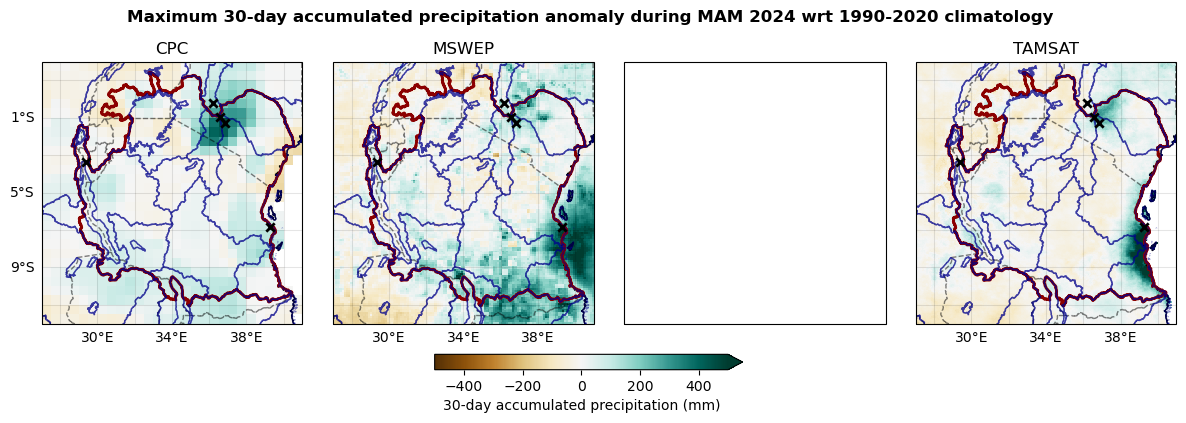

In [80]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)


v = {"30" : 500, "60" : 750}[str(ndays)]

for i in range(4):
    ds = datasets[i]
    if ds == "chirps": continue
    da = obs[ds].sel(time = "2024") - obs[ds].sel(time = slice("1990", "2020")).mean("time")
    ax = axs[i]
    
    cbar = da.plot(ax = ax, cmap = "BrBG", add_colorbar = False, vmin = -v, vmax = v)
    ax.set_title(ds.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    hybas04.boundary.plot(ax = ax, color = "darkblue", lw = 1, alpha = 0.5)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])

plt.suptitle("Maximum "+str(ndays)+"-day accumulated precipitation anomaly during MAM 2024 wrt 1990-2020 climatology", fontweight = "bold", y = 1.01)
plt.colorbar(cbar, ax = axs, location = "bottom", label = str(ndays)+"-day accumulated precipitation (mm)", fraction = 0.05, pad = 0.1, extend = "max")

plt.savefig("fig/rx"+str(ndays)+"day_gridded-fit_2024-anomaly.png")

# Linear trends in climate models


## HighResMIP

In [104]:
ndays = 30

outpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/eastAfrica_floods/highresmip/"
lfits = {}

for fnm in glob.glob(outpath+"*.nc"):
    
    mdl = "_".join(fnm.split("_")[-3:-1])
    if mdl == 'NICAM16-9S_r1i1p1f1': continue
    da = convert_units_to(xr.open_dataset(fnm).pr, "mm/day")
    rx30day_map = da.rolling(time = ndays).sum().groupby("time.season")["MAM"].resample(time = "AS-JAN").max().sel(time = slice(None, "2024"))
    
    lfits[mdl] = qfit(rx30day_map)

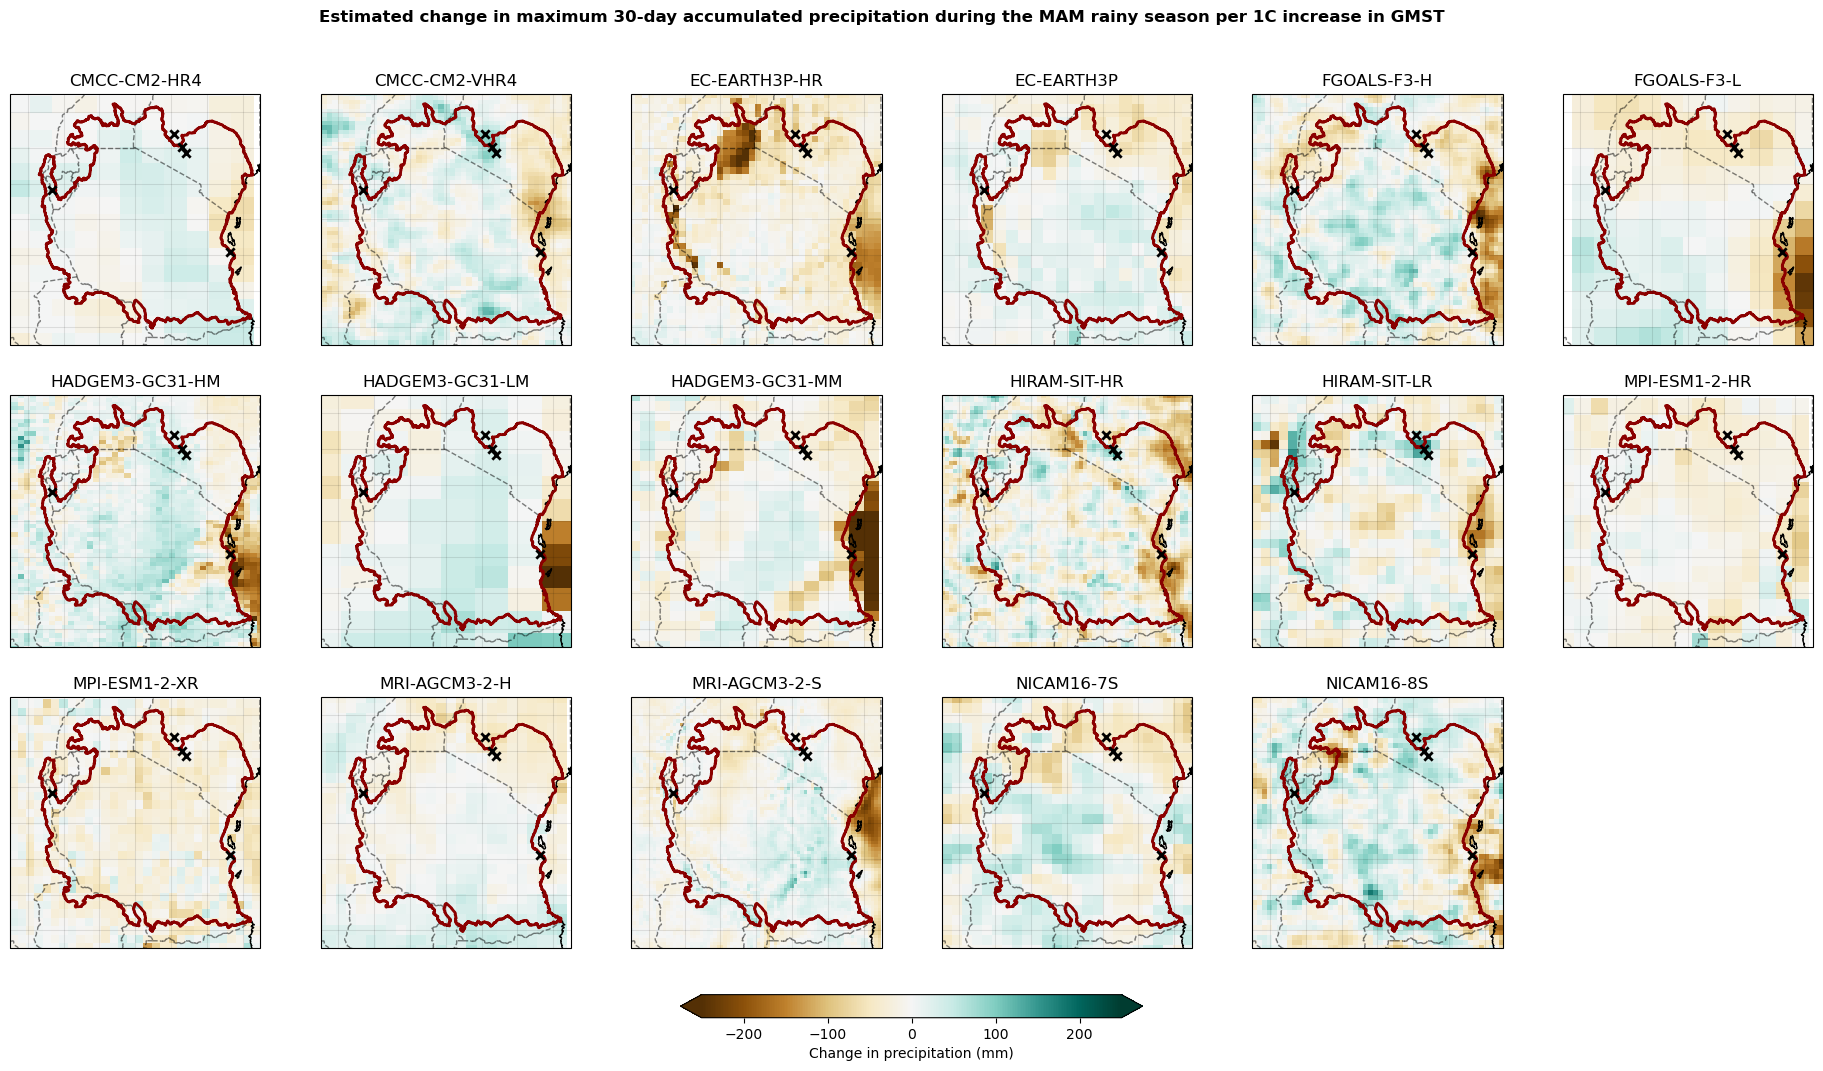

In [118]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (24,12), dpi = 100, sharex = True, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.01)

v = 250

for i in range(18):
    
    ds = sorted(list(lfits.keys()))[i]
    if ds == 'NICAM16-9S_r1i1p1f1': continue
        
    da = lfits[ds]["coef"].sel(degree = 1)
    ax = fig.axes[i]
    
    cbar = da.plot(ax = ax, cmap = "BrBG", vmin = -v, vmax = v, add_colorbar = False)
    ax.set_title(ds.upper().split("_")[0])
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)
    
# axs[:,0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])
# axs[0,:].gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])

fig.axes[-1].set_axis_off()
plt.colorbar(cbar, ax = axs, location = "bottom", label = "Change in precipitation (mm)", fraction = 0.025, pad = 0.05, extend = "both")
plt.suptitle("Estimated change in maximum "+str(ndays)+"-day accumulated precipitation during the MAM rainy season per 1C increase in GMST", fontweight = "bold", y = 0.95)

plt.savefig("fig/rx"+str(ndays)+"day_gridded-fit_linear-trend_highresmip.png")

# Nonstationary GEV fitted to gridded data

## Reshape dataframe into maps

In [14]:
warnings.filterwarnings("ignore", category = FutureWarning) # otherwise there will be a LOT of warnings


def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [41]:
ndays = 30
datasets = ["chirps", "cpc", "mswep"]
for ds in datasets:
    
    new_fnm = "res/res-gridded_rx"+str(ndays)+"day_"+ds+".nc"
    if os.path.exists(new_fnm): continue
    
    # load map to be used to reshape
    tmplt = xr.open_dataset("data/map-tmplt_"+ds+".nc").pr
    
    df = merge_byindex([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("data/gridded-res/rx"+str(ndays)+"day*_"+ds+"*.csv"))])
    mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
    mdl_res.to_netcdf(new_fnm)

## Plot maps

In [42]:
ndays = 30
datasets = ["chirps", "cpc", "mswep"]

# load results of model fitted to gridded data
da_res = { ds : xr.open_dataset("res/res-gridded_rx"+str(ndays)+"day_"+ds+".nc") for ds in datasets }

In [77]:
plot_kwargs = {
               "mu0"        : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "disp"       : {"cmap" : "viridis", "vmin" : 0},
               "alpha_gmst" : {"cmap" : "BrBG", "vmin" : -250, "vmax" : 250},
               "event_magnitude" : {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 750},
               "return_period"   : {"cmap" : "viridis", "norm" : matplotlib.colors.LogNorm(vmin = 1, vmax = 1e3)},
               "PR"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 10},
               "dI_rel" : {"cmap" : "BrBG", "vmin" : -100, "vmax" : 100},
              }

main = {
        "alpha_gmst" : "Change in rx"+str(ndays)+"day-MAM (mm) per 1C increase in GMST",
        "dI_rel" : "% change in rx"+str(ndays)+"day-MAM due to 1.2C increase in GMST",
        "event_magnitude" : "Maximum "+str(ndays)+"day precipitation during MAM 2024 (mm)",
        "PR" : "Change in likelihood due to 1.2C increase in GMST",
        "return_period" : "Return period of 2024 event",
       }

label = {
         "alpha_gmst" : "Change in rx"+str(ndays)+"day-MAM (mm)",
         "dI_rel" : "% change in rainy season precipitation",
         "event_magnitude" : "Accumulated precipitation (mm)",
         "PR" : "Probability ratio",
         "return_period" : "Return period (years)",
        }

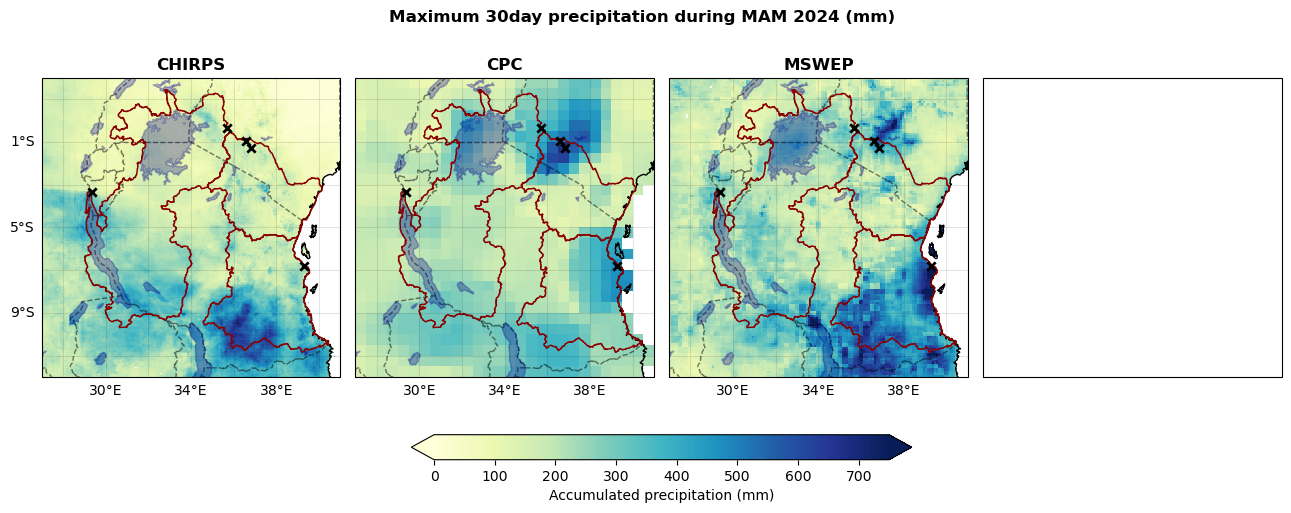

In [99]:
varnm = "event_magnitude"

fig, axs = plt.subplots(ncols = 4, figsize = (16,5), dpi = 100, subplot_kw={"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.05)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.065, "shrink" : 0.9, "pad" : 0.15, "extend" : "both"} | {"label" : label[varnm]}

for i in range(len(datasets)):
    ds = datasets[i]
    da = da_res[ds]
    ax = axs[i]
    
    cbar = da[varnm].plot(ax = ax, add_colorbar = False, **plot_kwargs[varnm])
    
    ax.set_title(ds.upper(), fontweight = "bold")
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
#     ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.1, xlocs = range(xn-1,xx,2), ylocs = range(yn-1,yx,2))
    
    sf_lv.boundary.plot(ax = ax, color = "darkred", lw = 1)
    sf_tc.boundary.plot(ax = ax, color = "darkred", lw = 1)
    sf_ch.boundary.plot(ax = ax, color = "darkred", lw = 1)
    
    ax.scatter(px.lon, px.lat, marker = "x", color = "k", lw = 2, zorder = 99)
    ax.gridlines(color = "k", alpha = 0, xlocs = range(xn-1,xx,4), draw_labels = ["bottom"])
    
axs[0].gridlines(color = "k", alpha = 0, ylocs = range(yn-1,yx,4), draw_labels = ["left"])
plt.colorbar(cbar, ax = axs, **cbar_kwargs)
plt.suptitle(main[varnm], fontweight = "bold", y = 1.01)
    
plt.savefig("fig/fitted-models-gridded_"+varnm+".png")